In [2]:
import scipy.io
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
from PIL import Image
from scipy.spatial.distance import euclidean

current_directory = os.getcwd()
svhn_directory = os.path.join(current_directory,"SVHN")

### Loading the Data
SVHN data is saved as two subsets. One subset has the raw image data with no labels and the other has 32x32 data saved in a .mat file. We can use scipy.io to load the .mat file and then use np to convert it to usable data. SVHN is unusual because instead of being saved as one-hot encoding vectors, they are saved as pixel arrays (with RGB channels). 

In [3]:
def load_svhn_data_mat(file_path):
    mat_data = scipy.io.loadmat(file_path)

    # Extract data and labels
    train_images = mat_data['X']
    train_labels = mat_data['y']
    # print(train_labels)

    # Reshape the images to (num_samples, height, width, channels)
    train_images = np.transpose(train_images, (3, 0, 1, 2))

    return train_images, train_labels

filepath = os.path.join(svhn_directory,"train_32x32.mat")
train_images, train_labels = load_svhn_data_mat(filepath)

filepath = os.path.join(svhn_directory,"test_32x32.mat")
test_images, test_labels = load_svhn_data_mat(filepath)

In [4]:
# Metadata
# The train labels is in a weird data structure
print(f"Unique Labels: {len(set([i[0] for i in train_labels]))}")
print("Train Dataset Shape:")
print(train_images.shape)
print("Train Labels Shape:")
print(train_labels.shape)
print("Test Dataset Shape:")
print(test_images.shape)


Unique Labels: 10
Train Dataset Shape:
(73257, 32, 32, 3)
Train Labels Shape:
(73257, 1)
Test Dataset Shape:
(26032, 32, 32, 3)


### Class Balance
Occasionally, balancing the train data can prevention biased models when the data is extremely balanced towards a certain class. Here, the train and test data frequency is plotted. SVHN's classes are quite unbalanced so balancing this data might be very valuable. Balancing the train data is done after the data is converted to a pandas df with flattened one-hot encoding vectors. Unfortunately, balancing might decrease accuracy since we throw out significant amounts of data. 

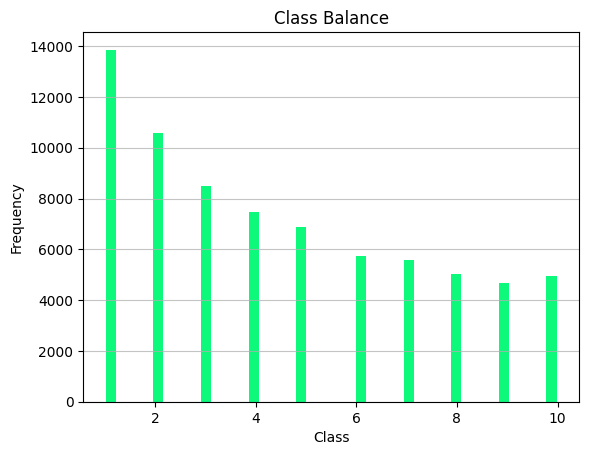

In [9]:
plt.hist(train_labels, bins='auto', color='#0cf97c', rwidth=0.85)


plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

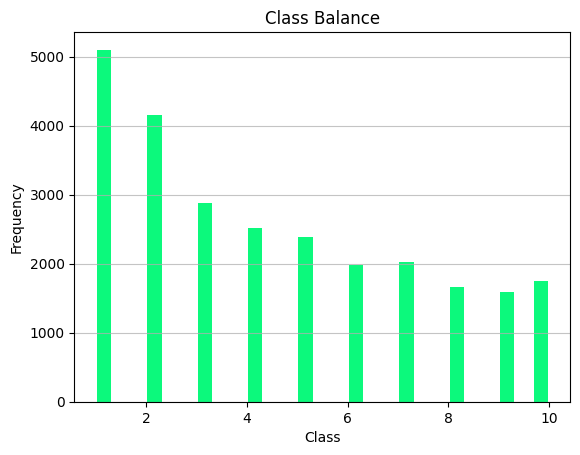

In [10]:
plt.hist(test_labels, bins='auto', color='#0cf97c', rwidth=0.85)


plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

### Transforming viewable image data to one-hot vectors 
SVHN is unique because it is the only dataset to be saved as images and not a one-hot vector. For computational purposes, it's important to have the one-hot vector available so instead of writing a function to convert the vector to a viewable image, we'll be doing the reverse. The images are split into 3 images representing the Red, Blue, and Green pixel values. Then, those images are flattened from 32x32 images to 1x1024 vectors and the three vectors are concatenated to get a vector of size 3072 for each image. 

The convert_to_images function is still needed to display images after operations have been done on the one-hot vectors. We'll reuse it from the CIFAR10 summary statistics notebook.

In [13]:
def flatten(images):
    """
    Flattens images back to a one hot vector format

    Parameters:
    - images: Numpy array representing the images with shape (num_images, height, width, channels)

    Returns:
    - Flat array where the first 1024 values represent the red channel, the next 1024 values represent the green channel,
      and the last 1024 values represent the blue channel of pixels for each image.
    Example:    
        flat_array = flatten(train_images)
    """
    num_images, _, _, _ = images.shape

    # Reshape the images array to (num_images, 1024, 3)
    reshaped_images = images.reshape((num_images, -1, 3))

    # Split the reshaped array into red, green, and blue channels
    red_channel = reshaped_images[:, :, 0]
    green_channel = reshaped_images[:, :, 1]
    blue_channel = reshaped_images[:, :, 2]

    # Stack the three channels horizontally
    stacked_channels = np.hstack([red_channel, green_channel, blue_channel])

    return stacked_channels

def convert_to_images(data_array):
    """
    Convert a single record into a viewable image. While we transform the entire dataset below, 
    this function will be useful if we do operations on one-hot vectors and 
    need to view the output as an human-interpretable image

    Parameters:
    - One-hot vector the first 1024 values represent the red channel of pixels, the second 1024 values represent the green channel of pixels, and the last 1024 values represent the blue channel of pixels

    Returns: 
    - a numpy array representing the image data

    Example:
        # Sample an element from image data to convert to PIL Image
        image = Image.fromarray(cifar_train_images.astype(np.uint8)[7], 'RGB')

        # # Display the image (optional)
        image.show()
        print(train_labels[7])
    """
    num_images = data_array.shape[0]
    image_size = 32

    # Split the array into three parts
    split_size = data_array.shape[1] // 3
    red_channel = data_array[:, :split_size]
    green_channel = data_array[:, split_size:2*split_size]
    blue_channel = data_array[:, 2*split_size:]
    print(f"Red Shape: {red_channel.shape}")
    print(f"Green Shape: {green_channel.shape}")
    print(f"Blue Shape: {blue_channel.shape}")

    # Stack the three parts horizontally
    stacked_channels = np.dstack([red_channel, green_channel, blue_channel])
    # print(stacked_channels.shape)

    # Reshape the stacked array into a 3D array
    images = stacked_channels.reshape((num_images, image_size, image_size, 3))

    return images

In [14]:
# Convert the data into one-hot vectors
flattened_train_data = flatten(train_images)
data_dict = {'pixel_{}'.format(i+1): flattened_train_data[:, i] for i in range(flattened_train_data.shape[1])}
data_dict['label'] = [i[0] for i in train_labels]

flattened_train_df = pd.DataFrame(data_dict)
flattened_train_df.head()


,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,pixel_3072,label
0,33,15,15,42,67,68,68,74,78,88,...,86,86,82,86,85,87,87,86,79,1
1,84,86,77,84,81,61,27,20,48,76,...,88,80,80,86,87,85,88,88,80,9
2,19,20,25,24,26,29,27,28,39,53,...,243,242,244,241,240,237,235,232,231,2
3,18,15,11,10,10,31,44,53,58,59,...,208,213,221,229,236,239,233,231,225,3
4,108,111,120,126,129,129,127,125,122,121,...,158,156,155,153,150,146,146,148,149,2


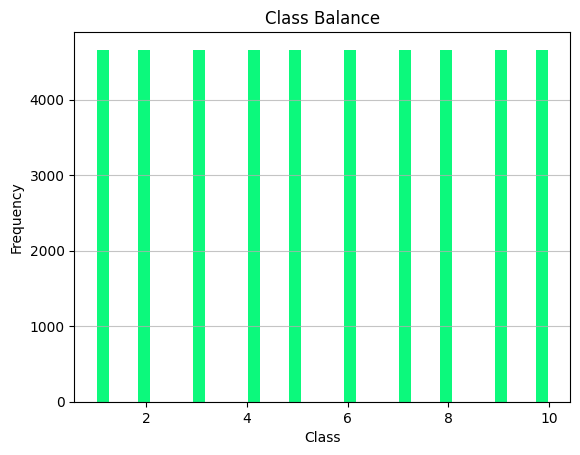

In [15]:
class_counts = flattened_train_df['label'].value_counts()
min_class_count = class_counts.min()
balanced_flattened_train_df = flattened_train_df.groupby('label').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)
balanced_flattened_train_df = balanced_flattened_train_df.sample(frac=1).reset_index(drop=True)

plt.hist(balanced_flattened_train_df['label'], bins='auto', color='#0cf97c', rwidth=0.85)


plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [18]:
# Sample an Image from the dataset
image = Image.fromarray(train_images[2].astype(np.uint8))
# Display the image
image.show()

### Mean Image Vector (per label)
SVHN only has 10 possible labels for their images so we can also compute a mean image for each label to get an idea of what the "average" image from each group will look like this. We do this by grouping the records by label, and then computing the mean of that group (column wise). 

SVHN are similar to MNIST in format but are not black and white and the photos might be taken from angles


Red Shape: (10, 1024)
Green Shape: (10, 1024)
Blue Shape: (10, 1024)


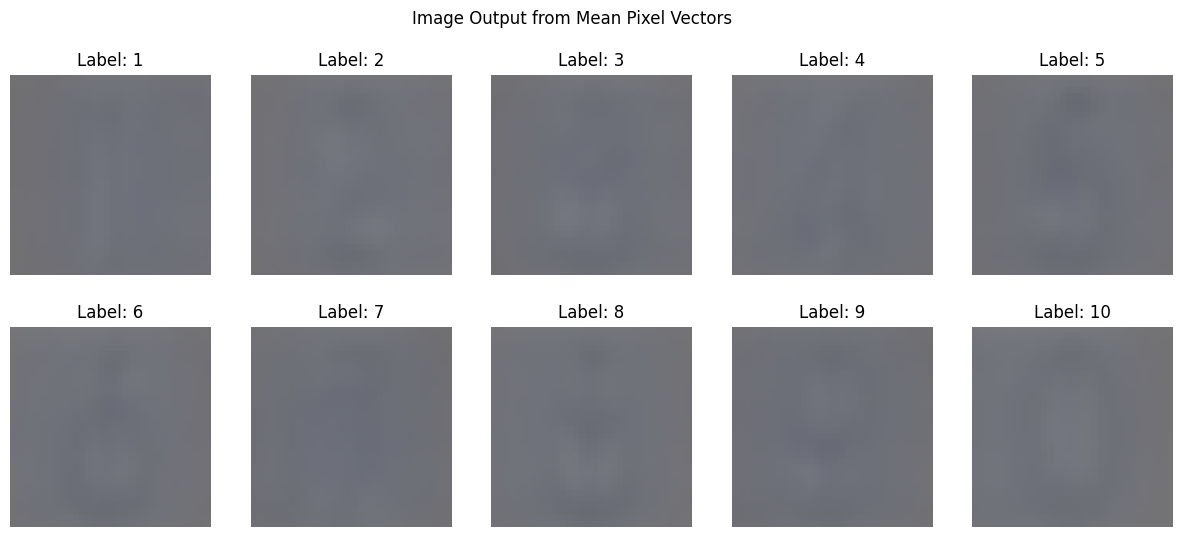

In [7]:
# Group by the first column (label) and compute the mean for each group\
grouped_means = flattened_train_df.groupby('label').mean().astype(int)
# print(grouped_means)

# Reset index 
grouped_means.sort_values(by='label')
grouped_means.reset_index(inplace=True, drop=True)

# Convert one-hot vectors to images
svhn_images = convert_to_images(grouped_means.to_numpy())

# Display the images as a 3x3 matrix using matplotlib
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Image Output from Mean Pixel Vectors')

for i in range(2):
    for j in range(5):
        index = i * 5 + j
        feature_image = svhn_images[index]
        
        axes[i, j].imshow(feature_image)
        axes[i, j].set_title(f"Label: {index+1}")
        axes[i, j].axis('off')


plt.show()

In [8]:
# This doesn't do anything but it helped me understand the pixel value ranges in the images above
for i in svhn_images:
    print(f"Min pixel value: {np.min(i)}")
    print(f"Max pixel value: {np.max(i)}")
    print(f"Avg pixel value: {np.mean(i)}\n\n")

Min pixel value: 108
Max pixel value: 125
Avg pixel value: 114.25651041666667


Min pixel value: 106
Max pixel value: 127
Avg pixel value: 115.47526041666667


Min pixel value: 105
Max pixel value: 127
Avg pixel value: 114.10807291666667


Min pixel value: 106
Max pixel value: 125
Avg pixel value: 114.92447916666667


Min pixel value: 103
Max pixel value: 125
Avg pixel value: 113.99186197916667


Min pixel value: 105
Max pixel value: 125
Avg pixel value: 115.19140625


Min pixel value: 105
Max pixel value: 123
Avg pixel value: 113.4033203125


Min pixel value: 104
Max pixel value: 126
Avg pixel value: 115.35872395833333


Min pixel value: 104
Max pixel value: 125
Avg pixel value: 113.51725260416667


Min pixel value: 107
Max pixel value: 126
Avg pixel value: 115.982421875




### Binarizing the mean vector 
The images in our dataset are very "grey" and do not have high contrast like MNIST. Therefore our mean images just become a grey blob. Unfortunately, that isn't very helpful to interpret as humans. To make more distinct shapes that humans can see, the mean images are greyscaled and then binarized. In the multidimensional vector space we'll still do computations with the euclidean distance from the mean vector since interpretability doesn't affect underlying patterns in multidimensional vector spaces. 

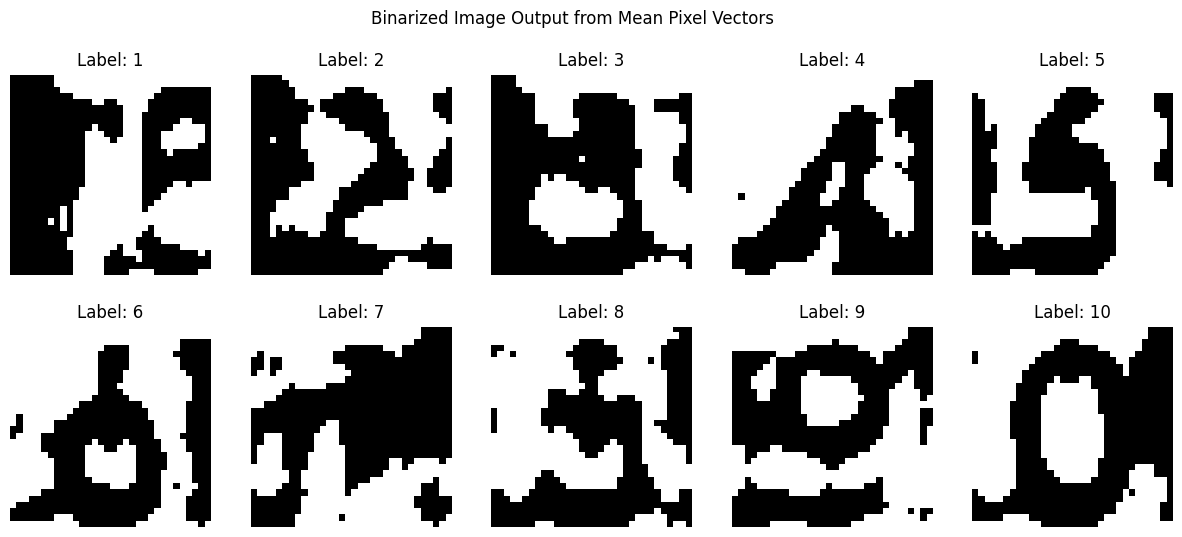

In [9]:
def binarize_by_mean(image):
    # Grayscale the image before binarization because RGB values mess with binarization
    grayscale_image = np.mean(image, axis=-1)
    # Compute mean pixel value for each image
    mean_pixel_value = np.mean(grayscale_image)
    
    # Binarize pixel values based on the mean
    binary_image = (grayscale_image  > mean_pixel_value).astype(int)
    
    return binary_image


# Apply binarization to each image in the svhn_images array
binarized_svhn_images = np.array([binarize_by_mean(image) for image in svhn_images])

# Display the binarized images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Binarized Image Output from Mean Pixel Vectors')

for i in range(2):
    for j in range(5):
        index = i * 5 + j
        feature_image = binarized_svhn_images[index]
        
        axes[i, j].imshow(feature_image, cmap='gray', vmin=0, vmax=1)
        axes[i, j].set_title(f"Label: {index+1}")
        axes[i, j].axis('off')

plt.show()

### Distance from the Mean Vector
To get an idea of how much images vary our mean vector we can calculate the euclidean distance of between each record and the mean record for that record's label. Summary statistics on our distances to will help measure how robust our dataset is.

In [10]:
# Calculate Euclidean distances between each vector and the mean vector
distances = {}

for index, row in flattened_train_df.iterrows():
    # labels are indexed at 1
    label = row['label'] - 1
    feature_data = row.iloc[:-1].to_numpy()
    mean_vector = grouped_means.iloc[label, :].to_numpy()

    distance = euclidean(feature_data, mean_vector)
    
    if label not in distances:
        distances[label] = []
    
    distances[label].append(distance)


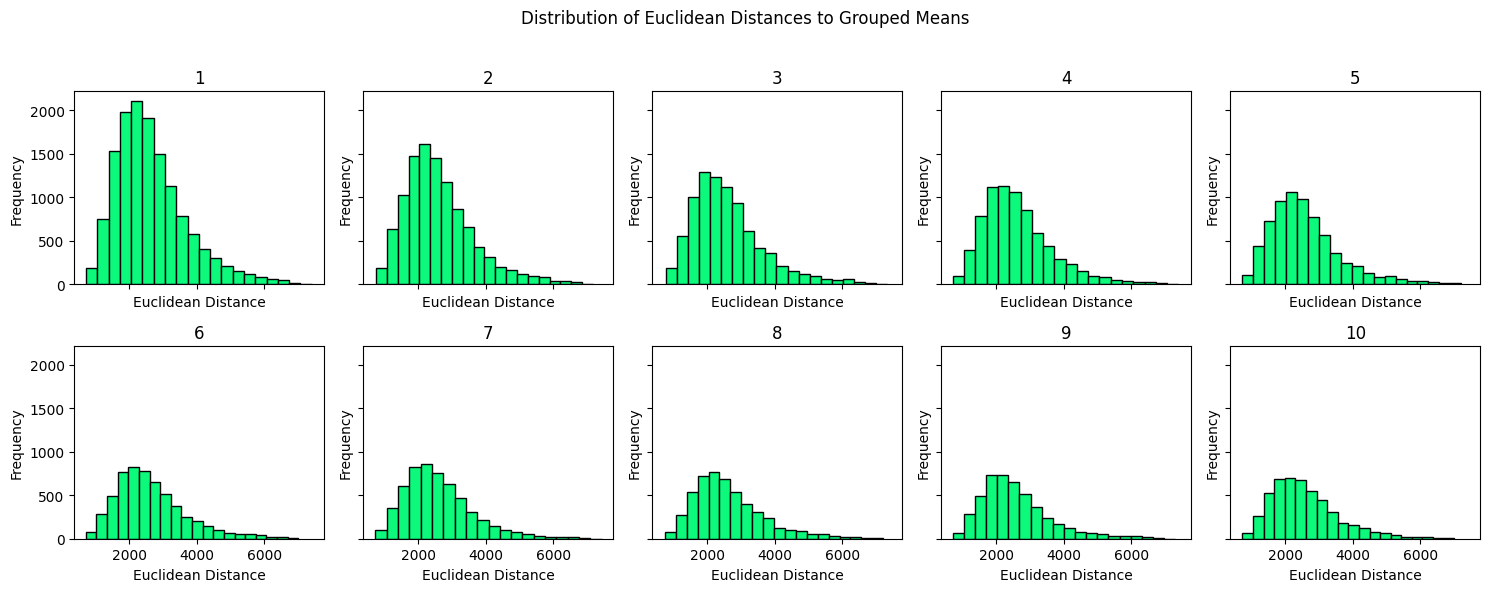

In [11]:
# Plotting Distances

# Create subplots for each label in increasing order
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle('Distribution of Euclidean Distances to Grouped Means')

# Sort labels in increasing order
sorted_labels = sorted(distances.keys())

# Plot histograms for each label
for i, label in enumerate(sorted_labels):
    dist_values = distances[label]
    ax = axes[i // 5, i % 5]
    ax.hist(dist_values, bins=20, color='#0cf97c', edgecolor='black')
    ax.set_title(f'{i+1}')
    ax.set_xlabel('Euclidean Distance')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [12]:
# Printing Summary Statistics to an output file for each label 

summary_statistics = {}

for label, dist_values in distances.items():
    summary_statistics[label] = {
        'Mean': round(np.mean(dist_values), 2),
        'Standard Deviation': round(np.std(dist_values), 2),
        'Variance': round(np.var(dist_values), 2),
        '25th Percentile': round(np.percentile(dist_values, 25), 2),
        'Median': round(np.median(dist_values), 2),
        '75th Percentile': round(np.percentile(dist_values, 75), 2),
        'Min': round(np.min(dist_values), 2),
        'Max': round(np.max(dist_values), 2)
    }

# Define the output file path
output_file_path = 'svhn_summary_statistics.txt'

# Open the output file and print summary statistics
with open(output_file_path, 'w') as output_file:
    for label in sorted(summary_statistics.keys()):
        stats = summary_statistics[label]
        output_file.write(f"Label {label} Summary Statistics:\n")
        for stat_name, stat_value in stats.items():
            output_file.write(f"{stat_name}: {stat_value}\n")
        output_file.write("\n")

print(f"Summary statistics saved to: {output_file_path}")


Summary statistics saved to: svhn_summary_statistics.txt
